# Data Loading and Preprocessing

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark_dist_explore

from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [3]:
import pyspark
import pyspark.sql.functions as F

In [ ]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

In [6]:
%cd /content/gdrive/MyDrive/kaggle

/content/gdrive/MyDrive/kaggle


In [ ]:
# !kaggle datasets download -d sobhanmoosavi/us-accidents

us-accidents.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
ls

kaggle.json                 spark-2.4.7-bin-hadoop2.7.tgz  us-accidents.zip
spark-2.4.7-bin-hadoop2.7/  US_Accidents_Dec20.csv


In [ ]:
# !unzip \*.zip  && rm *.zip

Archive:  us-accidents.zip
  inflating: US_Accidents_Dec20.csv  


In [8]:
df = (spark
  .read                                              
  .option("inferSchema","true")                 
  .option("header","true")                           
  .csv("gdrive/MyDrive/kaggle/US_Accidents_Dec20.csv"))

In [10]:
df.createOrReplaceTempView("df")

In [30]:
df.show()

+----+--------+-----+--------+-------------------+-------------------+---------+----------+-------+-------+------------+--------------------+------+--------------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|  Source|  TMC|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|Number|              Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Conditi

Only chossing the necessary column for EDA and impending new columns for Year and hour of start_time

In [11]:
df2 = spark.sql("Select Severity , Start_Time, End_Time, Side, City, State,  `Temperature(F)`, `Visibility(mi)`, Sunrise_Sunset, year(Start_Time) as Year, hour(Start_Time) as Start_hour from df")
df2.createOrReplaceTempView("df2")
df2.cache()

# df2.show()

DataFrame[Severity: int, Start_Time: timestamp, End_Time: timestamp, Side: string, City: string, State: string, Temperature(F): double, Visibility(mi): double, Sunrise_Sunset: string, Year: int, Start_hour: int]

In [12]:
for col in df2.columns:
  print(col, " with null values: ", df2.filter(df2[col].isNull()).count())

Severity  with null values:  0
Start_Time  with null values:  0
End_Time  with null values:  0
Side  with null values:  0
City  with null values:  137
State  with null values:  0
Temperature(F)  with null values:  89900
Visibility(mi)  with null values:  98668
Sunrise_Sunset  with null values:  141
Year  with null values:  0
Start_hour  with null values:  0


In [ ]:
# spark.sql("Select distinct Side, count(Side) from df5 group by Side").show()
che= spark.sql("Select distinct Side from df5 ").toPandas()
list(che['Side'])

['L', 'R']

We will remove records with null value for City and Sunrise_Sunset as it is very less compared to whole dataset and impend a new column for accident duration time

In [13]:
df3 = spark.sql("Select*, (cast(End_Time as Decimal)- cast(Start_Time as Decimal))/60 as Accident_Duration from df2 where Sunrise_Sunset is not NULL and City is not NULL and Side <> ' '")
df3.createOrReplaceTempView("df3")
df3.cache()
df3.show()

+--------+-------------------+-------------------+----+------------+-----+--------------+--------------+--------------+----+----------+-----------------+
|Severity|         Start_Time|           End_Time|Side|        City|State|Temperature(F)|Visibility(mi)|Sunrise_Sunset|Year|Start_hour|Accident_Duration|
+--------+-------------------+-------------------+----+------------+-----+--------------+--------------+--------------+----+----------+-----------------+
|       3|2016-02-08 05:46:00|2016-02-08 11:00:00|   R|      Dayton|   OH|          36.9|          10.0|         Night|2016|         5|       314.000000|
|       2|2016-02-08 06:07:59|2016-02-08 06:37:59|   L|Reynoldsburg|   OH|          37.9|          10.0|         Night|2016|         6|        30.000000|
|       2|2016-02-08 06:49:27|2016-02-08 07:19:27|   R|Williamsburg|   OH|          36.0|          10.0|         Night|2016|         6|        30.000000|
|       3|2016-02-08 07:23:34|2016-02-08 07:53:34|   R|      Dayton|   OH|  

In [ ]:
df3.describe().show()

+-------+------------------+-------+----------+-------+------------------+------------------+--------------+------------------+-----------------+------------------+
|summary|          Severity|   Side|      City|  State|    Temperature(F)|    Visibility(mi)|Sunrise_Sunset|              Year|       Start_hour| Accident_Duration|
+-------+------------------+-------+----------+-------+------------------+------------------+--------------+------------------+-----------------+------------------+
|  count|           4232400|4232400|   4232400|4232400|           4142505|           4133739|       4232400|           4232400|          4232400|           4232400|
|   mean| 2.305033078158964|   null|      null|   null|61.478028487594024| 9.112001938196904|          null|2018.4563167469994|12.13184623381533|    134.5863288541|
| stddev|0.5332175183377748|   null|      null|   null|18.525892754251302|2.8175859244739745|          null|1.3280272621386613|5.476415836485148|3524.8658346900197|
|    min| 

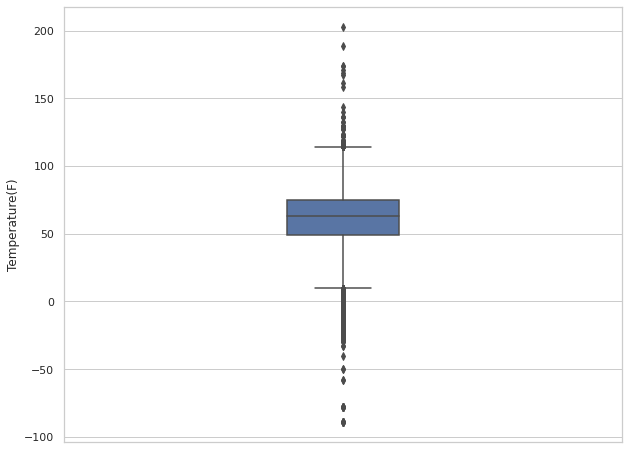

In [ ]:
# To show the outliers in Temp
a = spark.sql("Select `Temperature(F)` from df3").toPandas()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(y=a["Temperature(F)"],width=0.2)

In [ ]:
# checking average to replace NULL values in visibility 
b = spark.sql("Select Avg(`Visibility(mi)`) from df3")
b.show()

+-------------------+
|avg(Visibility(mi))|
+-------------------+
|  9.112001938196904|
+-------------------+



In [14]:
# Replacing NULL values with average in Temperature and visibility column
df4 = spark.sql("Select *, case when `Temperature(F)` is NULL then 61.478 else `Temperature(F)` end as Imp_Temp, case when `Visibility(mi)` is NULL then 9.0 else `Visibility(mi)` end as Imp_Visib from df3")
df4.createOrReplaceTempView("df4")
df4.cache()
df4.show()

+--------+-------------------+-------------------+----+------------+-----+--------------+--------------+--------------+----+----------+-----------------+--------+---------+
|Severity|         Start_Time|           End_Time|Side|        City|State|Temperature(F)|Visibility(mi)|Sunrise_Sunset|Year|Start_hour|Accident_Duration|Imp_Temp|Imp_Visib|
+--------+-------------------+-------------------+----+------------+-----+--------------+--------------+--------------+----+----------+-----------------+--------+---------+
|       3|2016-02-08 05:46:00|2016-02-08 11:00:00|   R|      Dayton|   OH|          36.9|          10.0|         Night|2016|         5|       314.000000|    36.9|     10.0|
|       2|2016-02-08 06:07:59|2016-02-08 06:37:59|   L|Reynoldsburg|   OH|          37.9|          10.0|         Night|2016|         6|        30.000000|    37.9|     10.0|
|       2|2016-02-08 06:49:27|2016-02-08 07:19:27|   R|Williamsburg|   OH|          36.0|          10.0|         Night|2016|         6|

In [ ]:
a.describe()

,Temperature(F)
count,4.142505e+06
mean,6.147803e+01
std,1.852589e+01
min,-8.900000e+01
25%,4.900000e+01
50%,6.300000e+01
75%,7.520000e+01
max,2.030000e+02


In [ ]:
IQR = 75.2-49
Median = 63
IQR*2.2


57.64000000000001

In [15]:
# To replace outliers with mean value of the Temperature
df5 = spark.sql("Select Severity , Start_Time, End_Time, Side, City, State,  Imp_Temp, Imp_Visib, Sunrise_Sunset, Year, Start_hour, Accident_Duration, case when (Imp_Temp-63 > 57.64 or 63-Imp_Temp >57.64) then 63 else Imp_Temp end as Final_Temp from df4")
df5.createOrReplaceTempView("df5")
df5.cache()

DataFrame[Severity: int, Start_Time: timestamp, End_Time: timestamp, Side: string, City: string, State: string, Imp_Temp: double, Imp_Visib: double, Sunrise_Sunset: string, Year: int, Start_hour: int, Accident_Duration: decimal(17,6), Final_Temp: double]

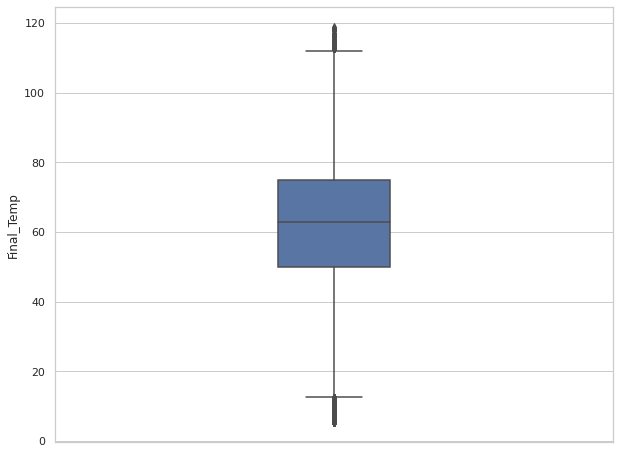

In [ ]:
c = spark.sql("Select Final_Temp from df5").toPandas()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(y=c["Final_Temp"],width=0.2)

In [16]:
df5.show()

+--------+-------------------+-------------------+----+------------+-----+--------+---------+--------------+----+----------+-----------------+----------+
|Severity|         Start_Time|           End_Time|Side|        City|State|Imp_Temp|Imp_Visib|Sunrise_Sunset|Year|Start_hour|Accident_Duration|Final_Temp|
+--------+-------------------+-------------------+----+------------+-----+--------+---------+--------------+----+----------+-----------------+----------+
|       3|2016-02-08 05:46:00|2016-02-08 11:00:00|   R|      Dayton|   OH|    36.9|     10.0|         Night|2016|         5|       314.000000|      36.9|
|       2|2016-02-08 06:07:59|2016-02-08 06:37:59|   L|Reynoldsburg|   OH|    37.9|     10.0|         Night|2016|         6|        30.000000|      37.9|
|       2|2016-02-08 06:49:27|2016-02-08 07:19:27|   R|Williamsburg|   OH|    36.0|     10.0|         Night|2016|         6|        30.000000|      36.0|
|       3|2016-02-08 07:23:34|2016-02-08 07:53:34|   R|      Dayton|   OH|  

In [31]:
df5.dtypes

[('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('End_Time', 'timestamp'),
 ('Side', 'string'),
 ('City', 'string'),
 ('State', 'string'),
 ('Imp_Temp', 'double'),
 ('Imp_Visib', 'double'),
 ('Sunrise_Sunset', 'string'),
 ('Year', 'int'),
 ('Start_hour', 'int'),
 ('Accident_Duration', 'decimal(17,6)'),
 ('Final_Temp', 'double')]

# Insights

Test:

In [ ]:
@interact
def show_articles_more_than(column='Severity', x=2):
    return df3.filter(df3[column] == x).count()

interactive(children=(Text(value='Severity', description='column'), IntSlider(value=2, description='x', max=6,…

In [17]:
# Common Function to add the list to dropdown
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = list(df5.select(array).distinct().toPandas()[array])
    unique.sort()
    unique.insert(0, ALL)
    return unique

Insight1: 

In [50]:
dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL('Year'), description = 'Year')

In [51]:
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(Year):
    output.clear_output()
    plt.clf()
    plot_output.clear_output()
    if (Year == ALL):
      common_filter = df5
      common_filter.createOrReplaceTempView("common_filter")
    else:
      common_filter = df5.filter(df5.Year == Year)
      common_filter.createOrReplaceTempView("common_filter")
    with output:
      common_filter.show()
    
    with plot_output:
      plot_output.clear_output()
      plt.close()
      # common_filter['Start_hour'].count().rdd.values().histogram()
      # sns.kdeplot(common_filter[-1], shade=True)
      # sns.distplot(common_filter['Start_hour'], bins = 24, kde = False , norm_hist = True)
      # plt.show()
      # bins, counts = common_filter.select('Start_hour').rdd.flatMap(lambda x: x).histogram(24)
      # plt.hist(bins[:-1], bins=bins, weights=counts)
      # common_filter_R = common_filter.filter(F.col('Side') == 'R').select(F.col('Start_hour').alias('Side_R'))
      # common_filter_L = common_filter.filter(F.col('Side') == 'L').select(F.col('Start_hour').alias('Side_L'))
      # fig, ax = plt.subplots()
      # hist(ax, df2.select('Start_hour'))
      # hist(ax, common_filter.select('Start_hour'), bins = 24, color=['red'])
      # hist(ax, [common_filter_R,common_filter_L], bins = 24, color=['red','tan'])
      # ax.legend()
      Data = spark.sql("Select Start_hour, count(Start_hour) as Count, Side from common_filter group by Start_hour, Side").toPandas()
      plt.figure(figsize=(10,8))
      sns.barplot(data= Data, x= 'Start_hour', y = 'Count', hue = 'Side')
      # x = Data['Count']
      # y = Data['Count']
      # my_colors = 'red'
      # plt.hist(x, bins = 24, color= my_colors)
      plt.show()
      # https://github.com/Bergvca/pyspark_dist_explore/ for the good histogram in spark

      # common_filter.groupby('Start_hour').count().plot.bar()
      # distplot( x= df3['Start_hour'], bins=24)

def dropdown_year_eventhandler(change):
  common_filtering(change.new)

dropdown_year.observe(dropdown_year_eventhandler, names='value')
display(dropdown_year)
# display(output)
display(plot_output)

Dropdown(description='Year', options=('ALL', 2016, 2017, 2018, 2019, 2020), value='ALL')

Output()

Insight 2: 

In [52]:
dropdown_severity = widgets.IntSlider(min=1, max=4, step=1, value=2, description = 'Severity') #(options = unique_sorted_values_plus_ALL('Severity'), description = 'Severity')

In [53]:
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(Severity):
    # output.clear_output()
    # plt.clf()
    plot_output.clear_output()
    if (Severity == ALL):
      common_filter = df5
      common_filter.createOrReplaceTempView("common_filter")
    else:
      common_filter = df5.filter(df5.Severity == Severity)
      common_filter.createOrReplaceTempView("common_filter")
    with output:
      common_filter.show()
    
    with plot_output:
      Data = spark.sql("Select Year, count(Severity) as Count from common_filter group by Year order by Year desc ").toPandas()
      plt.figure(figsize=(10,8))
      x = Data['Year']
      y = Data['Count']
      my_colors = 'rgbkymc'
      plt.bar(x, y, width=0.8, label='missing', color= my_colors)
      plt.show()

def dropdown_severity_eventhandler(change):
  common_filtering(change.new)

dropdown_severity.observe(dropdown_severity_eventhandler, names='value')
display(dropdown_severity)

display(plot_output)

IntSlider(value=2, description='Severity', max=4, min=1)

Output()

Insight 3:

In [54]:
dropdown_severity = widgets.IntSlider(min=1, max=4, step=1, value=2, description = 'Severity')

In [55]:
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(Severity):
    output.clear_output()
    plt.clf()
    plot_output.clear_output()
    common_filter = df5.filter(df5.Severity == Severity)
    common_filter.createOrReplaceTempView("common_filter")
    with output:
      common_filter.show()
    
    with plot_output:
      plot_output.clear_output()
      plt.close()
     
      Data = spark.sql("Select Start_hour, count(Start_hour) as Count, Year from common_filter group by Start_hour, Year").toPandas()
      plt.figure(figsize=(10,8))
      sns.barplot(data= Data, x= 'Start_hour', y = 'Count', hue = 'Year')
      
      plt.show()
     

def dropdown_severity_eventhandler(change):
  common_filtering(change.new)

dropdown_severity.observe(dropdown_severity_eventhandler, names='value')
display(dropdown_severity)

display(plot_output)

IntSlider(value=2, description='Severity', max=4, min=1)

Output()

Insight 4

In [56]:
dropdown_severity = widgets.IntSlider(min=1, max=4, step=1, value=2, description = 'Severity') #Dropdown(options = unique_sorted_values_plus_ALL('Severity'), description = 'Severity' )
dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL('Year'), description = 'Year')

In [57]:
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(Year, Severity):
    # plt.clf()
    plot_output.clear_output()
    if (Severity == ALL) & (Year == ALL):
      common_filter = df5
      common_filter.createOrReplaceTempView("common_filter")
    elif (Year == ALL):
      common_filter = df5.filter(df5.Severity == Severity)
      common_filter.createOrReplaceTempView("common_filter")
    elif (Severity == ALL):
      common_filter = df5.filter(df5.Year == Year)
      common_filter.createOrReplaceTempView("common_filter")   
    else:
      common_filter = df5.filter((df5.Year == Year) & (df5.Severity == Severity))
      common_filter.createOrReplaceTempView("common_filter")   
    with output:
      common_filter.show()
    
    with plot_output:
      Data = spark.sql("Select* from (Select * from (Select State, count(Severity) as Count from common_filter group by State) as a order by a.Count desc) as b LIMIT 10 ").toPandas()
      plt.figure(figsize=(10,8))
      x = Data['State']
      y = Data['Count']
      my_colors = 'rgbkymc'
      plt.bar(x, y, width=0.8, label='missing', color= my_colors)
      plt.show()

def dropdown_year_eventhandler(change):
  common_filtering(change.new,dropdown_severity.value)

def dropdown_severity_eventhandler(change):
  common_filtering(dropdown_year.value,change.new)

dropdown_severity.observe(dropdown_severity_eventhandler, names='value')
dropdown_year.observe(dropdown_year_eventhandler, names='value')

display(dropdown_severity)
display(dropdown_year)

display(plot_output)

IntSlider(value=2, description='Severity', max=4, min=1)

Dropdown(description='Year', options=('ALL', 2016, 2017, 2018, 2019, 2020), value='ALL')

Output()

# Appendix

In [ ]:
dropdown_state = widgets.Dropdown(options = unique_sorted_values_plus_ALL('State'), description = 'State')

Dropdown(description='State', options=('ALL', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA'…

Output()

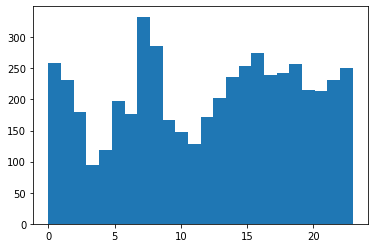

In [ ]:
# dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL('Year'))
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(State):
    output.clear_output()
    plt.clf()
    plot_output.clear_output()
    if (State == ALL):
      common_filter = df5
    else:
      common_filter = df5.filter(df5.State == State)
      
    with output:
      common_filter.show()
    
    with plot_output:
      plot_output.clear_output()
      plt.close()
      # common_filter['Start_hour'].count().rdd.values().histogram()
      # sns.kdeplot(common_filter[-1], shade=True)
      # sns.distplot(common_filter['Start_hour'], bins = 24, kde = False , norm_hist = True)
      # plt.show()
      # Show histogram of the 'C1' column
      bins, counts = common_filter.select('Start_hour').rdd.flatMap(lambda x: x).histogram(24)

      # This is a bit awkward but I believe this is the correct way to do it 
      plt.hist(bins[:-1], bins=bins, weights=counts)
      # distplot( x= df3['Start_hour'], bins=24)

def dropdown_state_eventhandler(change):
  common_filtering(change.new)

dropdown_state.observe(dropdown_state_eventhandler, names='value')
display(dropdown_state)
# display(output)
display(plot_output)

In [ ]:
dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL('Year'), description = 'Year')

In [ ]:
output = widgets.Output()
plot_output = widgets.Output()

def common_filtering(Year):
    output.clear_output()
    plt.clf()
    plot_output.clear_output()
    if (Year == ALL):
      common_filter = df5
      common_filter.createOrReplaceTempView("common_filter")
    else:
      common_filter = df5.filter(df5.Year == Year)
      common_filter.createOrReplaceTempView("common_filter")
    with output:
      common_filter.show()
    
    with plot_output:
      plot_output.clear_output()
      plt.close()
      
      Data = spark.sql("Select Start_hour, count(Start_hour) as Count, Severity from common_filter group by Start_hour, Severity").toPandas()
      plt.figure(figsize=(10,8))
      sns.barplot(data= Data, x= 'Start_hour', y = 'Count', hue = 'Severity')
      
      plt.show()

def dropdown_year_eventhandler(change):
  common_filtering(change.new)

dropdown_year.observe(dropdown_year_eventhandler, names='value')
display(dropdown_year)
# display(output)
display(plot_output)

Dropdown(description='Year', options=('ALL', 2016, 2017, 2018, 2019, 2020), value='ALL')

Output()